In [4]:
import sys
import stmpy
import numpy as np
from numpy import pi
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import time
import scipy.integrate as integrate
import scipy.special as special
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [127]:
def coef(w,geo,tip,t_array,harmonic):
    
    lock_coef = 1/(2*pi)
    
    ref_tip = np.sin(w*harmonic*2*pi*t_array) * tip
    ref_geo = np.sin(w*2*pi*t_array) * geo
    
    sos = signal.butter(10, w, 'lowpass', fs=1000, output='sos')
    filt_tip = signal.sosfilt(sos,ref_tip)
    filt_geo = signal.sosfilt(sos,ref_geo)
    
    
    lock_tip = integrate.trapz(t_array, filt_tip)
    lock_geo = integrate.trapz(t_array, filt_geo)
    mag = lock_tip/lock_geo

    return mag
#Functions for creating a stepwise frequency chirp
def chirp_amp_map(freq_map,t_array,harmonic_freq,harm_range,harmonic_type):
    
    period = 1/(freq_map)  #create an array of values indicating the period 
                            #length of their respective frequencies
    gauss_width = 2*period*(1/t_array[1]) #create an array of values indicating 
                                            #the amount of time needed for each respective 
                                            #frequency to perform 2 oscillations

    res_width = 0.0001
    res_freq = 1
    Q_factor = res_freq/res_width
    
    dropSz = len(t_array)    #Set the lenght of the established time array
    loc = np.where(freq_map[:-1] != freq_map[1:])[0]  #Identify the array location before a
                                                        #frequency changes values
    last = np.array([len(freq_map)-1])
    loc = np.append(loc,last)
    gauss_width = gauss_width[loc] #Identify the corresponding width values
    AmpMap = np.zeros(dropSz) #Initialize standard chirp amplitude map
    HarmMap = np.zeros(dropSz) #Initialize amplitude map of designated frequency values
    HarmMap_s = np.zeros(dropSz)
    prev = 0 #Initialize the previous point in the 
    for point,width in zip(loc,gauss_width):
        width = int(np.around(width))
        if prev >0:
            prev = prev+(width-prev_width)
        point_wid = point + width 

        tempMap = np.zeros(int(dropSz+2*width))#width acts as buffer for the convolution to not affect 
                                                #the ends of the array
        
        tempMap[int(prev+width/2)+1:int(point_wid-width/2)-1] = 1
        
        tempHarmMap = np.zeros(int(dropSz+2*width))
        tempHarmMap_s = np.zeros(int(dropSz+2*width))
        closest = min(absolute(harmonic_freq-freq_map[point]))
        if closest <= harm_range:
            tempHarmMap[int(prev+width/2)+1:int(point_wid-width/2)-1] = 1
        if closest >= harm_range:
            if harmonic_type == 'square_s':
                tempHarmMap_s[int(prev+width/2)+1:int(point_wid-width/2)-1] = 1
        
    
        prev = point_wid
        prev_width = width
        
        window = signal.hamming(width)
        tempMap = signal.convolve(tempMap,window,mode='same')/sum(window)
        tempHarmMap = signal.convolve(tempHarmMap,window,mode='same')/sum(window)
        tempHarmMap_s = signal.convolve(tempHarmMap_s,window,mode='same')/sum(window)
        AmpMap = AmpMap + tempMap[width:-width]
        HarmMap = HarmMap + tempHarmMap[width:-width]
        HarmMap_s = HarmMap_s + tempHarmMap_s[width:-width]

    return AmpMap,loc,HarmMap,HarmMap_s

#Time at each frequency is equal to the designated number of periods
#   Output is a waveform of the chirp and the determined time
def chirp_wave(period = 10, res=0.1, final_freq=10, freq_time = 100,
               timer = False, chirp_type = 'exponential', harmonic_freq = None,delta = 0.01,
               harmonic_number = 1, harm_range = 0.2,harmonic_type='square',View = False):
    fs = 1000
    if timer:
        t1 = time.time()
    freq_base = linspace(res,final_freq,int((final_freq)/res))
    harm_base = np.zeros(len(freq_base))
    for harm_freq in harmonic_freq:
        closest = np.where(absolute(freq_base-harm_freq)<=harm_range)
        harm_base[closest] = freq_base[closest]
        
    if chirp_type == 'exponential':
        t_len = int(sum(period/freq_base))
        peat_num = np.around((period/freq_base)*fs).astype('int')
        freq_vec = repeat(freq_base,peat_num)
        harm_vec = repeat(harm_base,peat_num)
    if chirp_type == 'linear':
        t_len = (final_freq/res)*freq_time
        peat_num = np.around((t_len/final_freq)*fs).astype('int')
        freq_vec = repeat(freq_base,peat_num)
        harm_vec = repeat(harm_base,peat_num)
        
    t_vec = linspace(0,t_len,t_len*fs)
    
    vec_dif = int(len(t_vec)-len(freq_vec))
   
    if vec_dif > 0:   #time vector is bigger take some off end
        t_vec = t_vec[:-vec_dif]
    elif vec_dif < 0:   #freq vector is bigger take some off beginning
        freq_vec = freq_vec[absolute(vec_dif):]
        harm_vec = harm_vec[absolute(vec_dif):]
    else:
        pass
     
    amp,loc,harm_amp,harm_amp_s = chirp_amp_map(freq_vec,t_vec,harmonic_freq,harm_range,harmonic_type)
#     plot(t_vec,amp)
#     plot(t_vec,harm_amp)
    chirp = amp*np.sin(2*np.pi*freq_vec*t_vec)
    harmonic_chirp = np.copy(chirp)
    for i in arange(harmonic_number):
        if harmonic_type == 'square':
            i = i*2+3
            amp_fract = 1/i
            freq_harm = freq_vec * i
            harmonic_chirp = harmonic_chirp + amp_fract*harm_amp*sin(2*pi*freq_harm*t_vec)
        if harmonic_type == 'square_s':
            A = 1
            f = 1/(2*pi)
            harmonic_chirp = harm_amp_s*np.sin(2*np.pi*freq_vec*t_vec)  + (
                harm_amp/arctan(1/delta))*arctan(sin(2*pi*t_vec*freq_vec)/delta)
        else:
            pass
    if View == True:
        figsize(15,6)
#         plot(t_vec,chirp)
        plot(t_vec,harmonic_chirp)
#         plot(t_vec,amp)
#         plot(t_vec,harm_amp)
        plot(t_vec[loc],chirp[loc],'.')
        tick_params(labelsize=12,colors='white')
        xlabel('Time (secs)',size=20,color='white')
        ylabel('Amplitude',size=20,color='white')
    
    if timer:
        print('Chirp generation time: ',np.round(time.time()-t1,2),'sec')
        
    return chirp,t_vec,loc,freq_base,harmonic_chirp

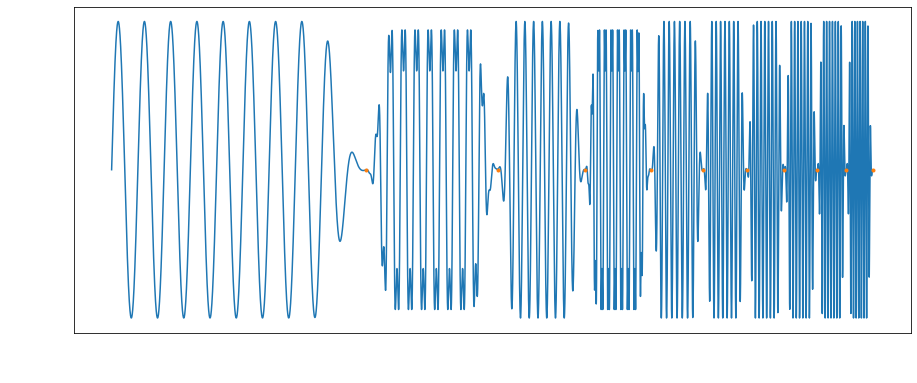

In [129]:
chirp,t_vec,loc,freqs,harmonic_chirp = chirp_wave(harmonic_freq=[2,4,12],res=1,View=True,
                                                  harmonic_type='square')


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
0.22921276092529297


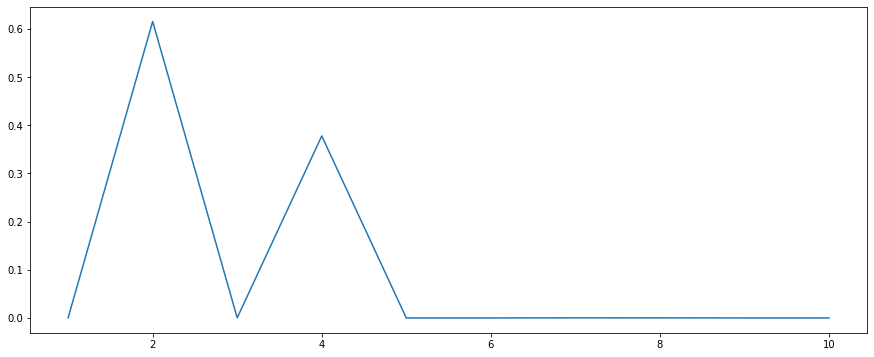

In [144]:
prev = 0
start = time.time()
harmonics = 20
C = np.zeros((len(freqs),harmonics),dtype='complex128')
C_1 = np.zeros(len(freqs),dtype='complex128')
print(freqs)
for w,point,i in zip(freqs,loc,arange(len(freqs))):
    input_wave = chirp[prev:point]
    output_wave = harmonic_chirp[prev:point]
    t_split = t_vec[prev:point]
    C_1[i] = coef(w,input_wave,output_wave,t_split,4)
    for j in arange(harmonics):
        C[i,j] = coef(w,input_wave,output_wave,t_split,(j+1))
    prev = point
print(time.time()-start)
for k in arange(harmonics):
    num = k+1
    string = str(num)+'st'+' Harmonic'
#     plot(freqs,C[:,j],label=string)
# plot(freqs,C[:,0])
plot(freqs,C_1)
# plot(freqs,C_1,'r',label='1st Harmonic')
# plot(freqs,C_3,'b',label='3rd Harmonic')
# plot(freqs,C_5,'k',label='5th Harmonic')
# plot(freqs,C_7,'m',label='7th Harmonic')
# plot(freqs,C_9,'c',label='9th Harmonic')
# plot(freqs,C_11,'y',label='11th Harmonic')
# tick_params(labelsize=12,colors='white')
# xlabel('Frequency (Hz)',size=20,color='white')
# ylabel('Magnitude of coefficient',size=20,color='white')
# title('Coefficient Calculation',size=20,color='white')
# legend()
# ylim(0,1.5)

(0, 1)

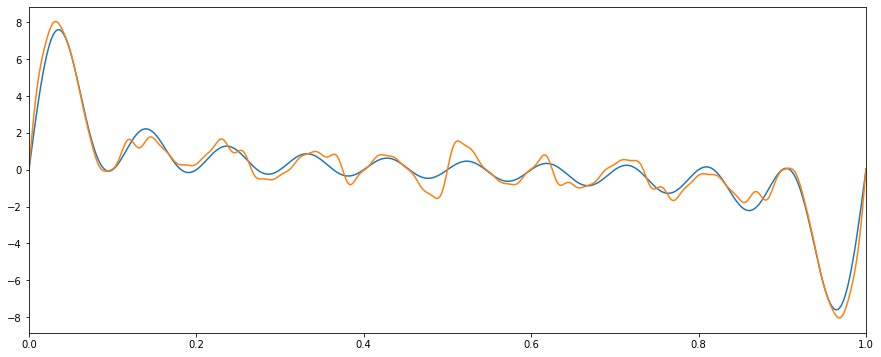

In [104]:
t = linspace(0,10,10000)
freq_test = arange(10) + 1
harmonics = arange(5)*2 +3

test_in = np.zeros(len(t))
test_out = np.zeros(len(t))
amp = 1
for w in freq_test:
    test_in = test_in + amp*sin(2*pi*t*w)
    test_out = test_out + amp*sin(2*pi*t*w)
    if absolute(w-2) <= 0.2:
        for h in harmonics:
            w_h = w*h
            amp_h = amp/h
            test_out = test_out + amp_h*sin(2*pi*t*w_h)
    if absolute(w-4) <= 0.2:
        for h in harmonics:
            w_h = w*h
            amp_h = amp/h
            test_out = test_out + amp_h*sin(2*pi*t*w_h)
test_in_fft = fft.fft(test_in)
out_approx = C_1
plot(t,test_in)
plot(t,test_out)
xlim(0,1)

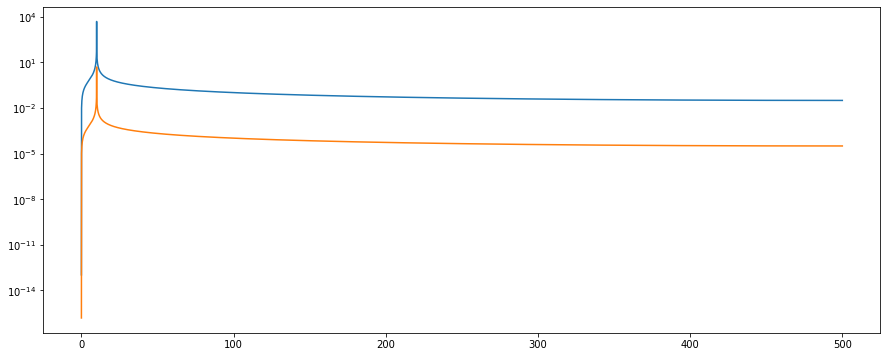

In [13]:
figsize(15,6)
t_len = 10
fs = 1000
t = linspace(0,t_len,t_len*fs)
amp = 1
amp_convert = 1e-3
noise = 1e-1*np.random.random(len(t))
princ = 10

x = amp*np.sin(princ*2*pi*t)
y = amp_convert*(amp*np.sin(princ*2*pi*t))# +amp*0.33333*np.sin(princ*3*2*pi*t) + amp*0.2*np.sin((princ*5)*2*pi*t))

# x = signal.chirp(t,0,t_len,10)
# y = signal.chirp(t,0,t_len,10)

x_fft = np.fft.fft(x)
y_fft = np.fft.fft(y)
freqs = np.fft.fftfreq(len(x),1/fs)
semilogy(freqs[:int(len(freqs)/2)],absolute(x_fft[:int(len(freqs)/2)]))
semilogy(freqs[:int(len(freqs)/2)],absolute(y_fft[:int(len(freqs)/2)]))

lin = y_fft/x_fft

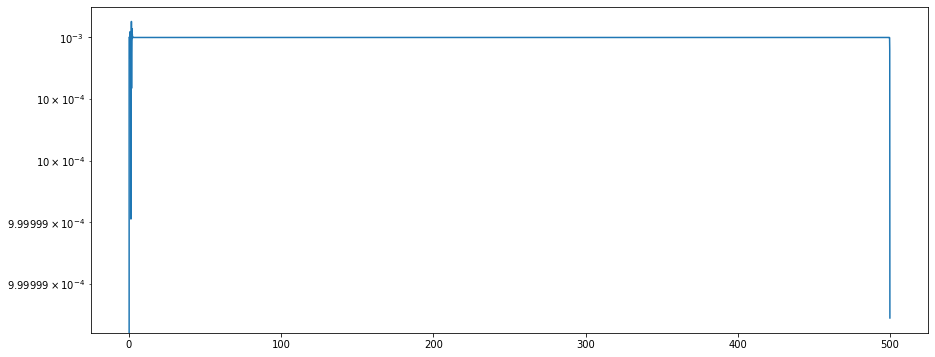

In [14]:
figsize(15,6)
C_1 = np.zeros(len(freqs),dtype='complex128')
C_3 = np.zeros(len(freqs),dtype='complex128')
C_5 = np.zeros(len(freqs),dtype='complex128')


for w in arange(int(len(freqs)/2)-1):
    w = w+1
    print(w,end='\r')
    C_1[w] = coef(freqs[w],x,y,t,1)
#     C_3[w] = coef(freqs[w],x,y,t,3)
#     C_5[w] = coef(freqs[w],x,y,t,5)

C_1[int(len(freqs)/2)+1:] = np.flip(C_1[1:int(len(freqs)/2)])
# C_3[int(len(freqs)/2)+1:] = np.flip(C_3[1:int(len(freqs)/2)])
# C_5[int(len(freqs)/2)+1:] = np.flip(C_5[1:int(len(freqs)/2)])
semilogy(freqs[:int(len(freqs)/2)],absolute(C_1[:int(len(freqs)/2)]))
# xlim(0.01,50)

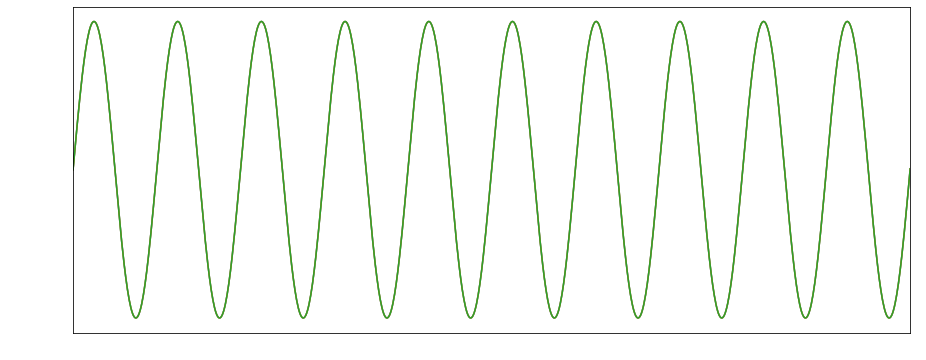

In [15]:
mat = np.fft.ifft(C_1*x_fft)
linap = np.fft.ifft(lin*x_fft)
plot(t,y)
plot(t,mat)
plot(t,linap)
xlim(0,1)
tick_params(labelsize=12,colors='white')

In [16]:
mag = coef(10,x,y,t,1)
print(mag)

0.0009999999999994417


In [17]:


# semilogy(freqs[:int(len(freqs)/2)],absolute(C_1[:int(len(freqs)/2)]))
# xlim(0,100)
# ylim(2.99999999,3.000000111)
# tick_params(labelsize=20,pad=6)

In [18]:
testx = signal.chirp(t,0,10,10)
testy = 3*signal.chirp(t,0,10,10)

w = 0+(10-0)*(t/t_len)
print(w[1000])
mag = coef(w[5],testx,testy,t,1)


1.000100010001


In [19]:
C_1 = np.zeros(len(t),dtype='complex128')
for i in arange(len(t)-3):
    print(i,end='\r')
    i = i+1
    temp_x = testx[i:i+2]
    temp_y = testy[i:i+2]
    C_1[i] = coef(w[i],temp_x,temp_y,t[i:i+2],1)

In [20]:
t = linspace(0,10,10000)
freq1 = 100
freq2 = 100.00001
control_wav = np.sin(freq1*2*pi*t)
test_wav = np.sin(freq2*2*pi*t)
ref = np.sin(freq1*2*pi*t)
lock1 = ref*control_wav
lock2 = ref*test_wav

sos = signal.butter(10, freq1, 'lowpass', fs=1000, output='sos')
filt_lock1 = signal.sosfilt(sos,lock1)
filt_lock2 = signal.sosfilt(sos,lock2)
control = integrate.trapz(t, filt_lock1)
test = integrate.trapz(t, filt_lock2)
print(control,test)

0.0033567772293169587 0.003355910639940672


In [21]:
t = linspace(0,10,10000)
freq1 = 100
control_wav = np.sin(freq1*2*pi*t)
ref = np.sin(freq1*2*pi*t)
lock1 = ref*control_wav
sos = signal.butter(10, freq1, 'lowpass', fs=1000, output='sos')
filt_lock1 = signal.sosfilt(sos,lock1)
control = np.zeros(100000)
test = np.zeros(100000)
for i in arange(100000):
    print(i,end='\r')
    freq2 = freq1 + i*1e-8
    test_wav = np.sin(freq2*2*pi*t)
    lock2 = ref*test_wav
    filt_lock2 = signal.sosfilt(sos,lock2)
    control[i] = integrate.trapz(t, filt_lock1)
    test[i] = integrate.trapz(t, filt_lock2)

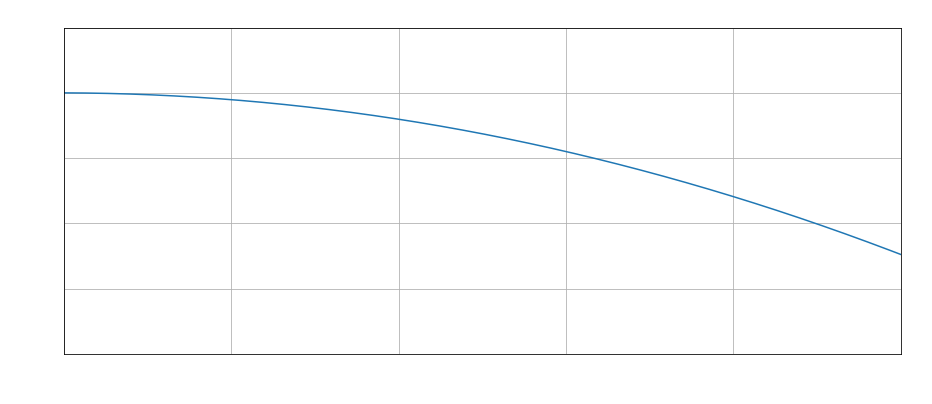

In [22]:
tick_params(labelsize=12,colors='white')
distance = 1e-8*arange(100000)
plot(distance,(test/control))
# plot(distance,(test))
# print(test[80000],control[80000])
xlabel('Variance of w',fontsize=20,color='white')
ylabel('Ratio of Tested/Control',fontsize=20,color='white')
title('Diversion of amplitude values with change in frequency',fontsize=20,color='white')
xlim(0,0.00025)
ylim(0.8,1.05)
grid()

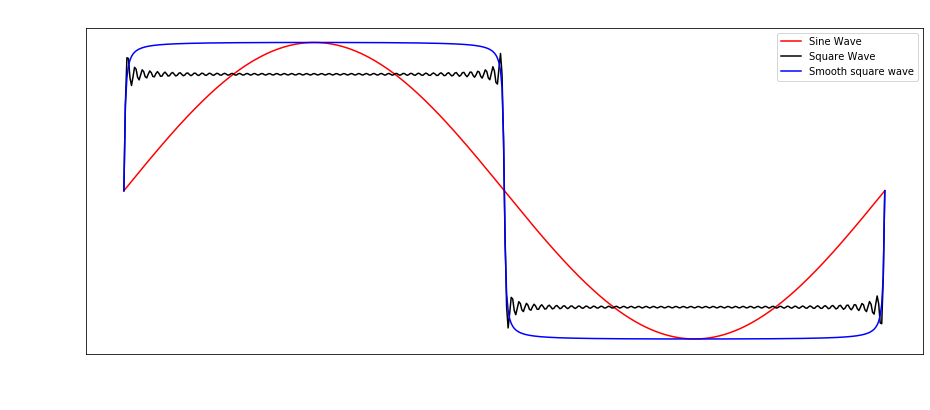

In [25]:
figsize(15,6)
tick_params(labelsize=20,colors='white')
t=linspace(0,2*pi,500)
delta = 0.01
A = 1
f = 1/(2*pi)
harmonics = 50
y1 = A*sin(2*pi*t*f)
y2 = A*sin(2*pi*t*f)
beta = 1
for i in arange(harmonics):
    i= i*2+3
    amp = (A/i)*beta
    freq = f*i
    y2 = y2 + amp*sin(2*pi*t*freq)
y3 = (A/arctan(1/delta))*arctan(sin(2*pi*t*f)/delta)

plot(t,y1,'r-',label='Sine Wave')
plot(t,y2,'k',label='Square Wave')
plot(t,y3,'b-',label='Smooth square wave')
xlabel('Time (Seconds)',color='white',FontSize=20)
ylabel('Amplitude',color='white',FontSize=20)
title('Smooth Square wave vs Square wave',color = 'white',size=20)
legend()

(1e-08, 1)

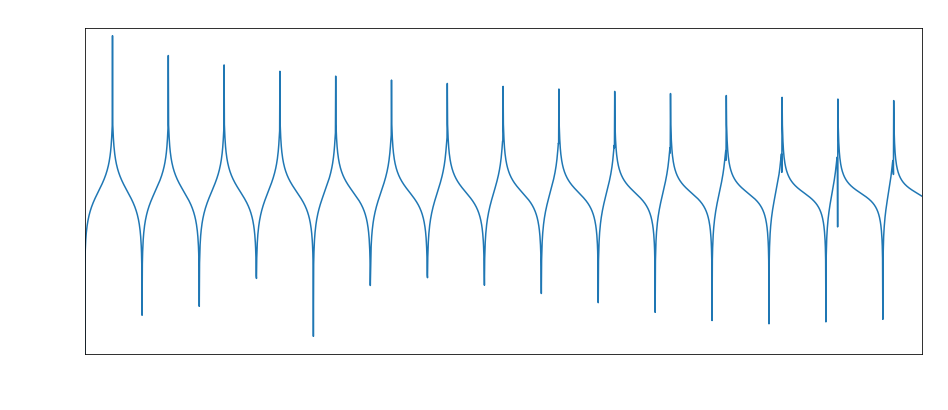

In [26]:
t = linspace(0,10,10000)
y3 = (A/arctan(1/delta))*arctan(sin(2*pi*t*10)/delta)
y3_fft = fft.fft(y3)/len(y3)
freqs = fft.fftfreq(len(y3),1/1000)
semilogy(freqs[:int(len(y3)/2)],absolute(y3_fft[:int(len(y3)/2)]))
tick_params(labelsize=20,colors='white')
title('Harmonic signature of smooth square wave',color='white',FontSize=20)
xlabel('Frequency (Hz)',color='white',FontSize=20)
ylabel('Amplitude',color='white',FontSize=20)
xlim(0,300)
ylim(1e-8,1)

1.0 2.8e-05 8e-06 5e-06 4e-06 3e-06
10.0 20.0 30.0 40.0 50.0 60.0


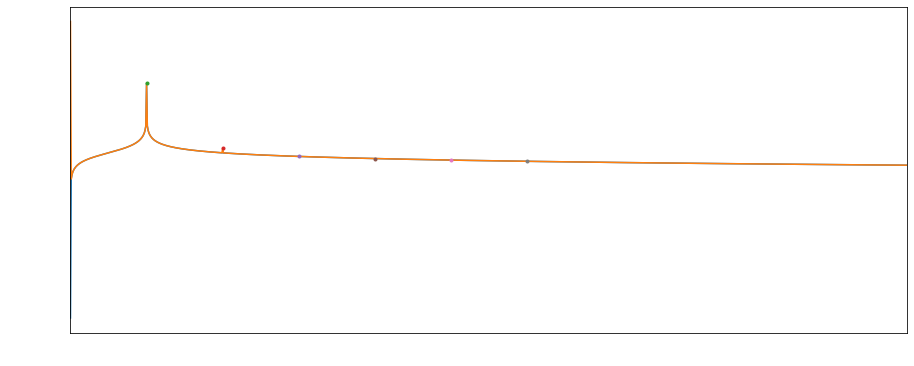

In [94]:
t = linspace(0,10,100000)
amp = 1e-4
noise = 0.011*amp*np.random.random(len(t))
x = amp*np.sin(10*2*pi*t)# + noise
y = exp(x)
x_fft = fft.fft(x)/len(x)
y_fft = fft.fft(y)/len(y)
freqs = fft.fftfreq(len(t),1/10000)
# plot(t,y)
# plot(t,x)
semilogy(freqs[:int(len(t)/2)],absolute(x_fft[:int(len(t)/2)]))
semilogy(freqs[:int(len(t)/2)],absolute(y_fft[:int(len(t)/2)]))
semilogy(freqs[100],absolute(y_fft[100]),'.')
semilogy(freqs[200],absolute(y_fft[200]),'.')
semilogy(freqs[300],absolute(y_fft[300]),'.')
semilogy(freqs[400],absolute(y_fft[400]),'.')
semilogy(freqs[500],absolute(y_fft[500]),'.')
semilogy(freqs[600],absolute(y_fft[600]),'.')
print(around(absolute(y_fft[100]/y_fft[100]),6),around(absolute(y_fft[200]/y_fft[100]),6),
      around(absolute(y_fft[300]/y_fft[100]),6),around(absolute(y_fft[400]/y_fft[100]),6),
      around(absolute(y_fft[500]/y_fft[100]),6),around(absolute(y_fft[600]/y_fft[100]),6))
print(freqs[100],freqs[200],freqs[300],freqs[400],freqs[500],freqs[600])
xlim(0,110)
tick_params(labelsize=20,colors='white')

(0, 30)

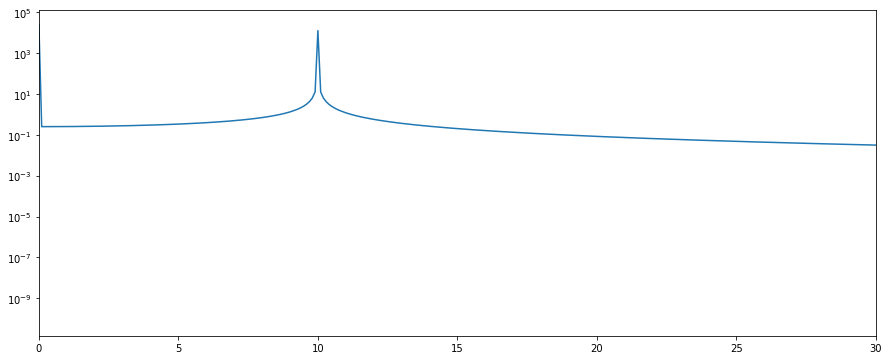

In [93]:
t = linspace(0,10,100000)
freq = 5
x = np.sin(freq*2*pi*t)
twox = np.fft.fft((x**2)/2)
e_x = 1 + x + (x**2)/2 + (x**3)/6
semilogy(freqs[:int(len(t)/2)],absolute(twox[:int(len(t)/2)]))
xlim(0,30)
# plot(t,x)
# plot(t,e_x)